# Perform Classification on the ADNI dataset

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
import torch
import torch.nn as nn
try:
    import cPickle as thepickle
except ImportError:
    import _pickle as thepickle
from IPython.display import display
import pickle
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
import sklearn.model_selection as model_selection
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from scipy.interpolate import interp1d
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier

### Read the data:

Instead of reading the whole database, we read only the data that's useful to us. That is, we read only specific columns of data, and we take only the row containing the first scan for each person. 

In "ADNI Regressional Analysis.ipynb" we have done that exactly, as well as performed linear regression transformation to the imaging data, in order to remove any age, sex, and DLICV_baseline effect. 

Furthermore, in "ADNI OPNMF.ipynb" we have performed dimensionality reduction through the OPNMF method, reducing the number of the ROIs from 145 to just 18. (Hasn't been done, so this does not apply)

Additionally, in "ADNI DeepCCA initial.ipynb" we have transformed the imaging and the genetic data using Deep Canonical Correlation Analysis to dimensionally reduced, maximally linearly correlated data. 

The data is located at "./DATA/ADNI_dataset.csv"
The transformed through LR data is located at "./DATA/Linearly_Transformed_Unique_Dataset.pkl"
The further transormed (through DCCA) data is located at "./DATA/ADNI_initial_DCCA_features.pkl"

(Need to run the RA and DCCA code if data is not found)

In [62]:
# Read the original data:
data = pd.read_csv("DATA/ADNI_dataset.csv", low_memory=False) # Need the low_memory or dtypes warning
data.replace({'Sex':{'F':1, 'M':0}}, inplace=True)

# The columns that interest us are the sex and age related, the ROIs, as well as the genetic data:
columns_of_interest = ['PTID',
                       'Date',
                       'Age', 
                       'Sex',
                       'DLICV_baseline',
                       'APOE4_Alleles',
                       'APOE_Genotype',
                       'Diagnosis_nearest_2.0']
c = list(data.columns)
MRI_columns = c[c.index("MUSE_Volume_4"):c.index("MUSE_Volume_207")+1]
genetic_columns = c[c.index("rs4575098"):c.index("rs429358")+1]

columns_of_interest += MRI_columns + genetic_columns

# Need the dropna because some first PTIDs have no MRI
data_of_interest = data[columns_of_interest].dropna(subset=['MUSE_Volume_4', 'DLICV_baseline'])


unique = data_of_interest.drop_duplicates(subset=['PTID'], keep='first')
u = unique.dropna() # only 2 values in Diagnosis_nearest_2.0' have NaN, easier to drop them:
unique = u
print(unique.shape)
unique.head(15)

(1567, 207)


,PTID,Date,Age,Sex,DLICV_baseline,APOE4_Alleles,APOE_Genotype,Diagnosis_nearest_2.0,MUSE_Volume_4,MUSE_Volume_11,...,rs28394864,rs111278892,rs3752246,rs4147929,rs41289512,rs3865444,rs6024870,rs6014724,rs7274581,rs429358
0,002_S_0295,2006-04-18,84.742466,0,1485405.375,1.0,E3/E4,CN,1873.124153,1586.249283,...,0,1,1,1,0,0,0,0,0,1
9,002_S_0413,2006-05-02,76.283562,1,1364116.000,0.0,E3/E3,CN,2131.516933,1505.034469,...,1,0,1,1,0,1,0,0,0,0
24,002_S_0559,2006-05-23,79.223288,0,1570479.625,1.0,E3/E4,CN,2366.717680,3157.732947,...,2,0,0,0,0,1,0,0,0,0
31,002_S_0619,2006-06-01,77.447945,0,1859348.250,2.0,E4/E4,Dementia,5124.734093,2981.605944,...,1,0,0,0,1,1,0,0,0,2
36,002_S_0685,2006-07-06,89.561644,1,1372862.125,0.0,E3/E3,CN,2941.520445,1693.826402,...,2,1,1,1,0,0,0,0,0,0
45,002_S_0729,2006-07-17,65.056164,1,1166961.750,1.0,E3/E4,MCI,966.095170,1921.643449,...,1,0,0,0,1,1,0,0,0,1
64,002_S_0816,2006-08-30,70.767123,0,1444128.125,2.0,E4/E4,Dementia,1427.160586,1604.163157,...,0,0,0,0,0,1,0,0,0,2
69,002_S_0938,2006-10-05,82.167123,1,1309685.000,0.0,E3/E3,Dementia,1931.131939,1136.952611,...,0,0,1,1,0,1,0,0,0,0
74,002_S_0954,2006-10-10,69.198630,1,1075661.500,1.0,E3/E4,MCI,707.696352,2621.956978,...,2,2,1,1,0,1,0,0,0,1
81,002_S_0955,2006-10-11,78.161644,1,1363607.000,1.0,E3/E4,Dementia,2681.014413,1374.257191,...,1,1,0,0,0,1,0,0,0,1


In [63]:
# Read the data transformed through the Regressional Analysis:
lr_data = pd.read_pickle("./DATA/Linearly_Transformed_Unique_Dataset.pkl")
print(lr_data.shape)
lr_data.head(15)

(1567, 207)


,PTID,Date,Age,Sex,DLICV_baseline,APOE4_Alleles,APOE_Genotype,Diagnosis_nearest_2.0,MUSE_Volume_4,MUSE_Volume_11,...,rs28394864,rs111278892,rs3752246,rs4147929,rs41289512,rs3865444,rs6024870,rs6014724,rs7274581,rs429358
0,002_S_0295,2006-04-18,84.742466,0,1485405.375,1.0,E3/E4,CN,-440.777069,-507.297168,...,0,1,1,1,0,0,0,0,0,1
9,002_S_0413,2006-05-02,76.283562,1,1364116.000,0.0,E3/E3,CN,577.755137,-188.813792,...,1,0,1,1,0,1,0,0,0,0
24,002_S_0559,2006-05-23,79.223288,0,1570479.625,1.0,E3/E4,CN,198.499249,1080.290951,...,2,0,0,0,0,1,0,0,0,0
31,002_S_0619,2006-06-01,77.447945,0,1859348.250,2.0,E4/E4,Dementia,2623.687012,649.558822,...,1,0,0,0,1,1,0,0,0,2
36,002_S_0685,2006-07-06,89.561644,1,1372862.125,0.0,E3/E3,CN,727.400228,-250.782773,...,2,1,1,1,0,0,0,0,0,0
45,002_S_0729,2006-07-17,65.056164,1,1166961.750,1.0,E3/E4,MCI,246.226215,628.340793,...,1,0,0,0,1,1,0,0,0,1
64,002_S_0816,2006-08-30,70.767123,0,1444128.125,2.0,E4/E4,Dementia,-145.138564,-193.593195,...,0,0,0,0,0,1,0,0,0,2
69,002_S_0938,2006-10-05,82.167123,1,1309685.000,0.0,E3/E3,Dementia,169.421397,-610.085153,...,0,0,1,1,0,1,0,0,0,0
74,002_S_0954,2006-10-10,69.198630,1,1075661.500,1.0,E3/E4,MCI,-81.664210,1343.833768,...,2,2,1,1,0,1,0,0,0,1
81,002_S_0955,2006-10-11,78.161644,1,1363607.000,1.0,E3/E4,Dementia,1036.385233,-353.324662,...,1,1,0,0,0,1,0,0,0,1


In [64]:
# Create a new dataset and drop the imaging and genetic data:
c = list(lr_data.columns)
MRI_columns = c[c.index("MUSE_Volume_4"):c.index("MUSE_Volume_207")+1]
genetic_columns = c[c.index("rs4575098"):c.index("rs429358")+1]
columns_to_drop = MRI_columns + genetic_columns
dcca_data = lr_data.drop(labels = columns_to_drop, axis=1)

# Read the data transformed through DCCA:
with open("./DATA/ADNI_initial_DCCA_features.pkl", 'rb') as f:
    dcca_transformed_data_file = pickle.load(f)
transformed_imaging_data = dcca_transformed_data_file[0]
transformed_genetic_data = dcca_transformed_data_file[1]
print("Transformed imaging data dimensions: \n" , transformed_imaging_data.shape)
print("Transformed genetic data dimensions: \n" , transformed_genetic_data.shape)

# Embed them into the new dataset:
imaging_labels = ["imaging_component_"+str(x+1) for x in range(transformed_imaging_data.shape[1])] 
genetic_labels = ["genetic_component_"+str(x+1) for x in range(transformed_genetic_data.shape[1])] 
dcca_data[genetic_labels] = transformed_genetic_data
dcca_data[imaging_labels] = transformed_imaging_data
print("DCCA Data Dimensions: \n",dcca_data.shape)
dcca_data.head(15)

Transformed imaging data dimensions: 
 (1567, 50)
Transformed genetic data dimensions: 
 (1567, 50)
DCCA Data Dimensions: 
 (1567, 108)


/opt/homebrew/Caskroom/miniconda/base/envs/DeepCCA/lib/python3.8/site-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)


,PTID,Date,Age,Sex,DLICV_baseline,APOE4_Alleles,APOE_Genotype,Diagnosis_nearest_2.0,genetic_component_1,genetic_component_2,...,imaging_component_41,imaging_component_42,imaging_component_43,imaging_component_44,imaging_component_45,imaging_component_46,imaging_component_47,imaging_component_48,imaging_component_49,imaging_component_50
0,002_S_0295,2006-04-18,84.742466,0,1485405.375,1.0,E3/E4,CN,9.296558e+05,-3.988535e+05,...,-7.426673e+05,-5.579362e+05,-1.812926e+06,-5.735780e+05,1.210753e+06,-5.518162e+05,-2.311037e+06,2.250669e+06,-2.423911e+06,1.354385e+06
9,002_S_0413,2006-05-02,76.283562,1,1364116.000,0.0,E3/E3,CN,8.101463e+05,-1.499785e+06,...,-1.897955e+06,-1.026957e+06,6.985402e+05,2.900572e+06,-9.792765e+05,-1.910373e+06,1.480384e+06,-9.730434e+04,2.208062e+06,1.919713e+06
24,002_S_0559,2006-05-23,79.223288,0,1570479.625,1.0,E3/E4,CN,1.198098e+06,-7.288923e+04,...,3.911640e+04,3.944699e+05,9.225376e+05,3.951529e+05,2.896765e+06,-5.650213e+05,2.741433e+06,1.384157e+06,4.187438e+04,1.224467e+06
31,002_S_0619,2006-06-01,77.447945,0,1859348.250,2.0,E4/E4,Dementia,1.131839e+06,-3.592919e+04,...,-4.886411e+05,1.739690e+06,1.245398e+06,-2.013759e+06,-2.793250e+06,-7.379401e+05,-2.199273e+06,-1.199920e+06,-2.118511e+06,2.198565e+05
36,002_S_0685,2006-07-06,89.561644,1,1372862.125,0.0,E3/E3,CN,-1.472448e+05,-2.382084e+05,...,8.898299e+05,1.298109e+06,-5.727100e+05,1.698264e+06,-1.617214e+06,1.739938e+06,-1.220055e+06,6.072980e+05,1.830694e+06,3.203096e+06
45,002_S_0729,2006-07-17,65.056164,1,1166961.750,1.0,E3/E4,MCI,1.067314e+05,1.440318e+05,...,-7.733254e+05,3.310542e+06,-1.510415e+06,-2.168774e+06,1.202617e+06,-1.702917e+06,-5.808022e+05,3.436810e+06,8.088985e+05,-6.164529e+05
64,002_S_0816,2006-08-30,70.767123,0,1444128.125,2.0,E4/E4,Dementia,1.643790e+06,9.654313e+04,...,1.119672e+06,2.155021e+06,4.637178e+04,-1.754107e+06,-1.343460e+06,3.211376e+06,-4.499323e+05,-1.428182e+06,2.254518e+06,1.908206e+06
69,002_S_0938,2006-10-05,82.167123,1,1309685.000,0.0,E3/E3,Dementia,-5.674039e+05,-3.437029e+06,...,-2.515732e+06,3.122902e+06,-9.308717e+05,2.489367e+05,1.740236e+06,-2.845651e+06,4.946758e+06,3.379630e+06,1.335185e+06,4.922473e+05
74,002_S_0954,2006-10-10,69.198630,1,1075661.500,1.0,E3/E4,MCI,2.556077e+06,-4.287198e+05,...,-1.079922e+06,1.426876e+06,-2.136677e+06,3.165175e+06,1.249644e+04,8.254365e+05,1.242980e+06,4.505199e+05,1.961754e+06,1.058673e+06
81,002_S_0955,2006-10-11,78.161644,1,1363607.000,1.0,E3/E4,Dementia,5.462088e+05,-1.196564e+06,...,3.726105e+05,1.706643e+06,-2.316185e+06,1.331207e+05,-5.916121e+05,-1.401667e+06,7.380135e+05,4.066118e+06,2.034088e+06,2.229305e+06


### Perform Classification using SVMs:

In [65]:
def perform_svm(X,Y,kern= None):
    X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, train_size=0.8, shuffle=True)
    if kern:
        s = svm.SVC(kernel = kern).fit(X_train, Y_train)
    else:
        s = svm.SVC().fit(X_train, Y_train)
    pred = s.predict(X_test)
    acc = accuracy_score(Y_test, pred)
    f1 = f1_score(Y_test, pred, average='weighted')
    cm = confusion_matrix(Y_test, pred)
    if kern == None:
        print('Accuracy (Linear Kernel): ', "%.2f" % (acc*100))
        print('F1 (Linear Kernel): ', "%.2f" % (f1*100))
    else:
        print('Accuracy ('+kern+' Kernel): ', "%.2f" % (acc*100))
        print('F1 ('+kern+' Kernel): ', "%.2f" % (f1*100))       
    return acc, f1, cm

In [66]:
Accuracies = []
F1s = []

##############################################################################  IMAGING + GENETIC without DCCA:
print("#################### IMAGING + GENETIC: ####################")
# Get the values that interest us:
X = lr_data[MRI_columns + genetic_columns]
Y = lr_data["Diagnosis_nearest_2.0"]

# Create 3 separate kernels for experimentation (increase max_iter because of warning):
lin_accuracy, lin_f1, lin_cm = perform_svm(X,Y)
poly_accuracy, poly_f1, poly_cm = perform_svm(X,Y,kern='poly')
rbf_accuracy, rbf_f1, rbf_cm = perform_svm(X,Y,kern='rbf')

Accuracies += lin_accuracy, poly_accuracy, rbf_accuracy
F1s += lin_f1, poly_f1, rbf_f1

############################################################################## IMAGING + GENETIC with DCCA:
print("#################### IMAGING + GENETIC DCCA: ####################")
# Get the values that interest us:
X = dcca_data[genetic_labels + imaging_labels]
Y = dcca_data["Diagnosis_nearest_2.0"]

# Create 3 separate kernels for experimentation (increase max_iter because of warning):
lin_accuracy, lin_f1, lin_cm_d = perform_svm(X,Y)
poly_accuracy, poly_f1, poly_cm_d = perform_svm(X,Y,kern='poly')
rbf_accuracy, rbf_f1, rbf_cm_d = perform_svm(X,Y,kern='rbf')

Accuracies += lin_accuracy, poly_accuracy, rbf_accuracy
F1s += lin_f1, poly_f1, rbf_f1

##############################################################################  IMAGING ONLY without DCCA:
print("#################### IMAGING: ####################")
# Get the values that interest us:
X = lr_data[MRI_columns]
Y = lr_data["Diagnosis_nearest_2.0"]

# Create 3 separate kernels for experimentation (increase max_iter because of warning):
lin_accuracy, lin_f1, lin_cm_i = perform_svm(X,Y)
poly_accuracy, poly_f1, poly_cm_i = perform_svm(X,Y,kern='poly')
rbf_accuracy, rbf_f1, rbf_cm_i = perform_svm(X,Y,kern='rbf')

Accuracies += lin_accuracy, poly_accuracy, rbf_accuracy
F1s += lin_f1, poly_f1, rbf_f1

############################################################################## IMAGING ONLY with DCCA:
print("#################### IMAGING DCCA: ####################")
# Get the values that interest us:
X = dcca_data[imaging_labels]
Y = dcca_data["Diagnosis_nearest_2.0"]

# Create 3 separate kernels for experimentation (increase max_iter because of warning):
lin_accuracy, lin_f1, lin_cm_d_i = perform_svm(X,Y)
poly_accuracy, poly_f1, poly_cm_d_i = perform_svm(X,Y,kern='poly')
rbf_accuracy, rbf_f1, rbf_cm_d_i = perform_svm(X,Y,kern='rbf')

Accuracies += lin_accuracy, poly_accuracy, rbf_accuracy
F1s += lin_f1, poly_f1, rbf_f1

##############################################################################  GENETIC ONLY without DCCA:
print("#################### GENETIC: ####################")
# Get the values that interest us:
X = lr_data[genetic_columns]
Y = lr_data["Diagnosis_nearest_2.0"]

# Create 3 separate kernels for experimentation (increase max_iter because of warning):
lin_accuracy, lin_f1, lin_cm_g = perform_svm(X,Y)
poly_accuracy, poly_f1, poly_cm_g = perform_svm(X,Y,kern='poly')
rbf_accuracy, rbf_f1, rbf_cm_g = perform_svm(X,Y,kern='rbf')

Accuracies += lin_accuracy, poly_accuracy, rbf_accuracy
F1s += lin_f1, poly_f1, rbf_f1

############################################################################## GENETIC ONLY with DCCA:
print("#################### GENETIC DCCA: ####################")
# Get the values that interest us:
X = dcca_data[genetic_labels]
Y = dcca_data["Diagnosis_nearest_2.0"]

# Create 3 separate kernels for experimentation (increase max_iter because of warning):
lin_accuracy, lin_f1, lin_cm_d_g = perform_svm(X,Y)
poly_accuracy, poly_f1, poly_cm_d_g = perform_svm(X,Y,kern='poly')
rbf_accuracy, rbf_f1, rbf_cm_d_g = perform_svm(X,Y,kern='rbf')

Accuracies += lin_accuracy, poly_accuracy, rbf_accuracy
F1s += lin_f1, poly_f1, rbf_f1

names = ['Both Linear without DCCA', 'Both Poly without DCCA', 'Both RBF without DCCA', 'Both Linear with DCCA',
         'Both Poly with DCCA', 'Both RBF with DCCA', 'Imaging Linear without DCCA', 'Imaging Poly without DCCA',
         'Imaging RBF without DCCA','Imaging Linear with DCCA', 'Imaging Poly with DCCA', 'Imaging RBF with DCCA',
         'Genetic Linear without DCCA', 'Genetic Poly without DCCA', 'Genetic RBF without DCCA', 'Genetic Linear with DCCA',
         'Genetic Poly with DCCA', 'Genetic RBF with DCCA']

max_acc = np.argmax(Accuracies)
print("Model with max Accuracy: ", names[max_acc], " with an Accuracy score of ", round(max(Accuracies)*100,3))
max_f1 = np.argmax(F1s)
print("Model with max F1 Score: ", names[max_f1], " with an F1 Score of ", round(max(F1s)*100,3))

#################### IMAGING + GENETIC: ####################
Accuracy (Linear Kernel):  54.14
F1 (Linear Kernel):  46.69
Accuracy (poly Kernel):  51.59
F1 (poly Kernel):  40.52
Accuracy (rbf Kernel):  52.55
F1 (rbf Kernel):  47.75
#################### IMAGING + GENETIC DCCA: ####################
Accuracy (Linear Kernel):  53.50
F1 (Linear Kernel):  42.51
Accuracy (poly Kernel):  51.27
F1 (poly Kernel):  43.25
Accuracy (rbf Kernel):  53.50
F1 (rbf Kernel):  42.56
#################### IMAGING: ####################
Accuracy (Linear Kernel):  56.69
F1 (Linear Kernel):  51.81
Accuracy (poly Kernel):  50.32
F1 (poly Kernel):  40.41
Accuracy (rbf Kernel):  50.96
F1 (rbf Kernel):  44.45
#################### IMAGING DCCA: ####################
Accuracy (Linear Kernel):  48.73
F1 (Linear Kernel):  38.97
Accuracy (poly Kernel):  50.96
F1 (poly Kernel):  43.64
Accuracy (rbf Kernel):  50.00
F1 (rbf Kernel):  41.69
#################### GENETIC: ####################
Accuracy (Linear Kernel):  51.27
F1

In [67]:
def barplot_scores(Accuracies, F1s, Names):
    barWidth = 0.2
    fig = plt.subplots(figsize =(14, 8))
    br1 = np.arange(len(Accuracies))
    br2 = [x + barWidth for x in br1] 
    plt.bar(br1, [100*x for x in Accuracies], color ='r', width = barWidth, edgecolor ='grey', label ='Accuracy')
    plt.bar(br2, [100*x for x in F1s], color ='b', width = barWidth, edgecolor ='grey', label ='F1 score')
    plt.xlabel('SVM', fontweight ='bold', fontsize = 15)
    plt.ylabel('Score', fontweight ='bold', fontsize = 15)
    plt.xticks([r + barWidth for r in range(len(Accuracies))],Names)
    plt.grid()
    plt.legend()
    plt.show()
    return

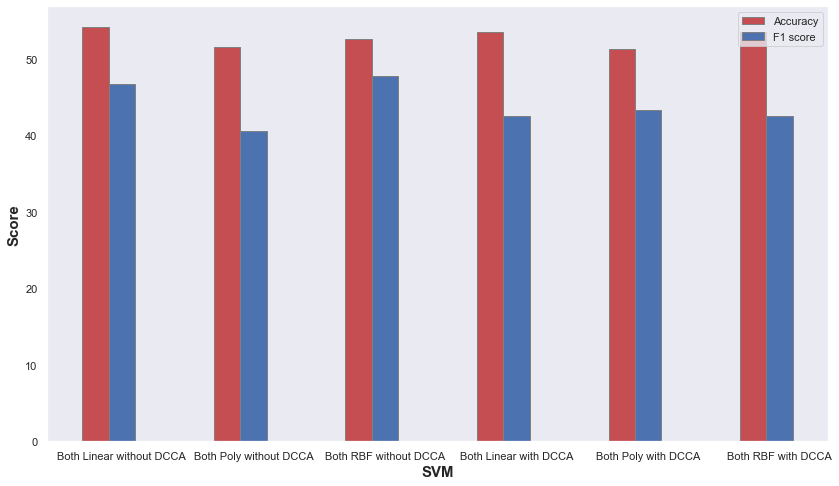

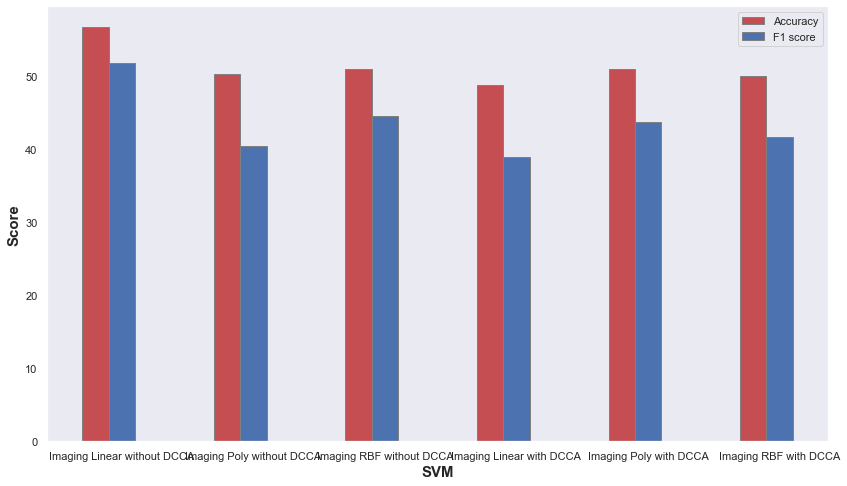

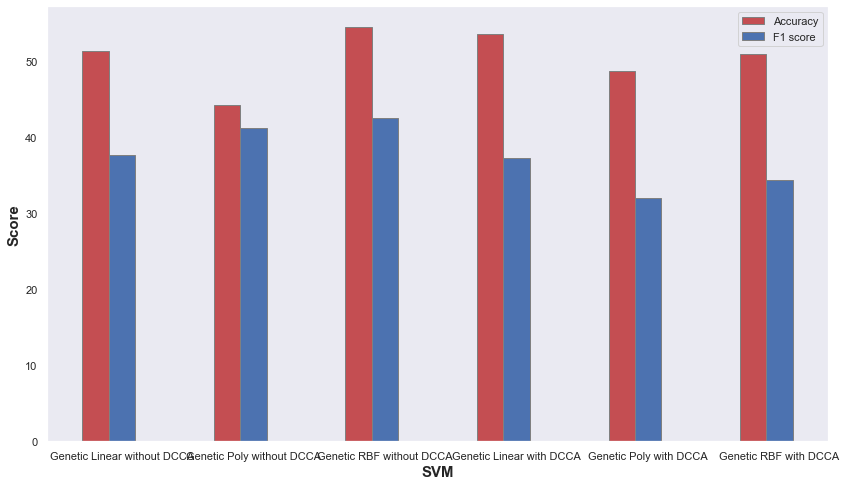

In [68]:
barplot_scores(Accuracies[0:6], F1s[0:6], 
               ['Both Linear without DCCA', 'Both Poly without DCCA', 'Both RBF without DCCA', 'Both Linear with DCCA',
                'Both Poly with DCCA', 'Both RBF with DCCA'])
barplot_scores(Accuracies[6:12], F1s[6:12], 
               ['Imaging Linear without DCCA', 'Imaging Poly without DCCA', 'Imaging RBF without DCCA',
                'Imaging Linear with DCCA', 'Imaging Poly with DCCA', 'Imaging RBF with DCCA'])
barplot_scores(Accuracies[12:18], F1s[12:18], 
               ['Genetic Linear without DCCA', 'Genetic Poly without DCCA', 'Genetic RBF without DCCA', 
                'Genetic Linear with DCCA','Genetic Poly with DCCA', 'Genetic RBF with DCCA'])

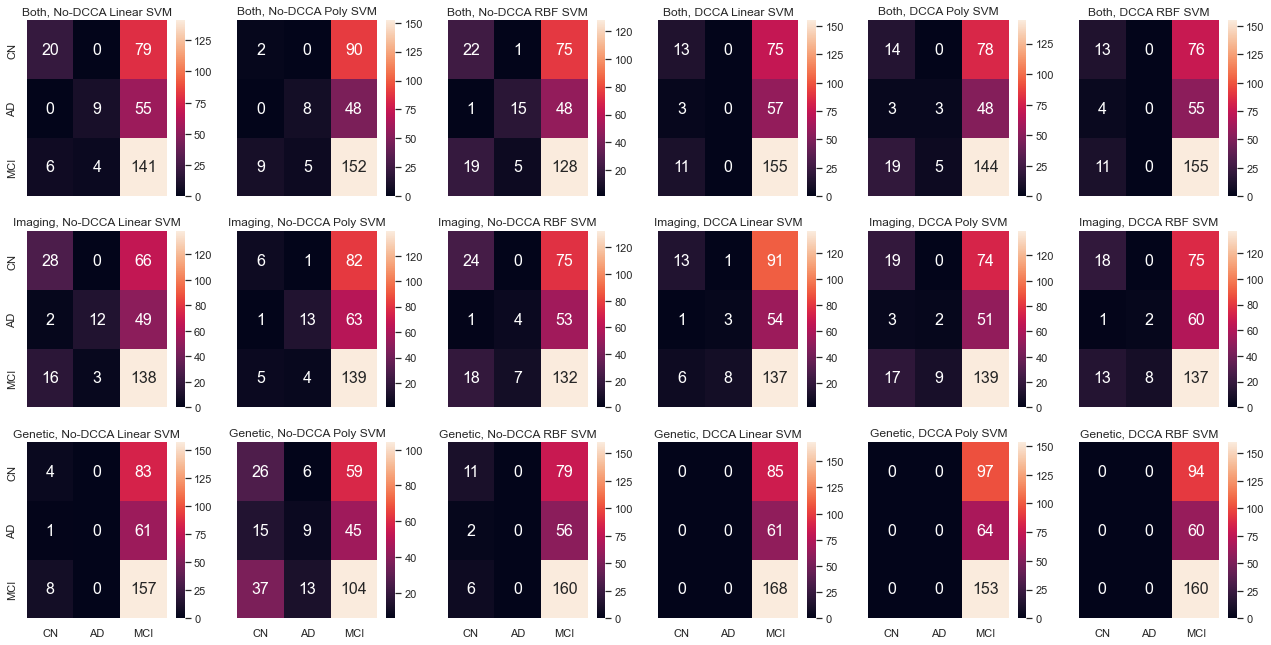

In [69]:
fig, axes = plt.subplots(nrows=3,ncols=6,figsize=(22,11));
sns.set(font_scale=1) # for label size
sns.heatmap(lin_cm, annot=True, annot_kws={"size": 16}, ax = axes[0][0], fmt='g',
           xticklabels = False, yticklabels = ["CN", "AD", "MCI"]).set_title("Both, No-DCCA Linear SVM")
sns.heatmap(poly_cm, annot=True, annot_kws={"size": 16}, ax = axes[0][1], fmt='g',
           xticklabels = False, yticklabels = False).set_title("Both, No-DCCA Poly SVM")
sns.heatmap(rbf_cm, annot=True, annot_kws={"size": 16}, ax = axes[0][2], fmt='g',
           xticklabels = False, yticklabels = False).set_title("Both, No-DCCA RBF SVM")
sns.heatmap(lin_cm_d, annot=True, annot_kws={"size": 16}, ax = axes[0][3], fmt='g',
           xticklabels = False, yticklabels = False).set_title("Both, DCCA Linear SVM")
sns.heatmap(poly_cm_d, annot=True, annot_kws={"size": 16}, ax = axes[0][4], fmt='g',
           xticklabels = False, yticklabels = False).set_title("Both, DCCA Poly SVM")
sns.heatmap(rbf_cm_d, annot=True, annot_kws={"size": 16}, ax = axes[0][5], fmt='g',
           xticklabels = False, yticklabels = False).set_title("Both, DCCA RBF SVM")
###
sns.heatmap(lin_cm_i, annot=True, annot_kws={"size": 16}, ax = axes[1][0], fmt='g',
           xticklabels = False, yticklabels = ["CN", "AD", "MCI"]).set_title("Imaging, No-DCCA Linear SVM")
sns.heatmap(poly_cm_i, annot=True, annot_kws={"size": 16}, ax = axes[1][1], fmt='g',
           xticklabels = False, yticklabels = False).set_title("Imaging, No-DCCA Poly SVM")
sns.heatmap(rbf_cm_i, annot=True, annot_kws={"size": 16}, ax = axes[1][2], fmt='g',
           xticklabels = False, yticklabels = False).set_title("Imaging, No-DCCA RBF SVM")
sns.heatmap(lin_cm_d_i, annot=True, annot_kws={"size": 16}, ax = axes[1][3], fmt='g',
           xticklabels = False, yticklabels = False).set_title("Imaging, DCCA Linear SVM")
sns.heatmap(poly_cm_d_i, annot=True, annot_kws={"size": 16}, ax = axes[1][4], fmt='g',
           xticklabels = False, yticklabels = False).set_title("Imaging, DCCA Poly SVM")
sns.heatmap(rbf_cm_d_i, annot=True, annot_kws={"size": 16}, ax = axes[1][5], fmt='g',
           xticklabels = False, yticklabels = False).set_title("Imaging, DCCA RBF SVM")
###
sns.heatmap(lin_cm_g, annot=True, annot_kws={"size": 16}, ax = axes[2][0], fmt='g',
           xticklabels = ["CN", "AD", "MCI"], yticklabels = ["CN", "AD", "MCI"]).set_title("Genetic, No-DCCA Linear SVM")
sns.heatmap(poly_cm_g, annot=True, annot_kws={"size": 16}, ax = axes[2][1], fmt='g',
           xticklabels = ["CN", "AD", "MCI"], yticklabels = False).set_title("Genetic, No-DCCA Poly SVM")
sns.heatmap(rbf_cm_g, annot=True, annot_kws={"size": 16}, ax = axes[2][2], fmt='g',
           xticklabels = ["CN", "AD", "MCI"], yticklabels = False).set_title("Genetic, No-DCCA RBF SVM")
sns.heatmap(lin_cm_d_g, annot=True, annot_kws={"size": 16}, ax = axes[2][3], fmt='g',
           xticklabels = ["CN", "AD", "MCI"], yticklabels = False).set_title("Genetic, DCCA Linear SVM")
sns.heatmap(poly_cm_d_g, annot=True, annot_kws={"size": 16}, ax = axes[2][4], fmt='g',
           xticklabels = ["CN", "AD", "MCI"], yticklabels = False).set_title("Genetic, DCCA Poly SVM")
sns.heatmap(rbf_cm_d_g, annot=True, annot_kws={"size": 16}, ax = axes[2][5], fmt='g',
           xticklabels = ["CN", "AD", "MCI"], yticklabels = False).set_title("Genetic, DCCA RBF SVM")
plt.show()


### Perform Classification using kNN:

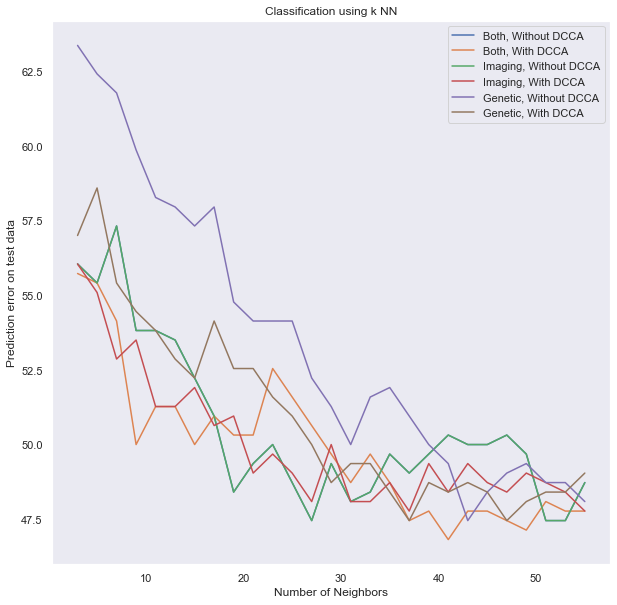

In [70]:
accs = []
accs_d = []
accs_i = []
accs_d_i = []
accs_g = []
accs_d_g = []

neighbors = [x for x in range(3,57,2)]
for nn in neighbors:
    
    knn = KNeighborsClassifier(n_neighbors=nn)
    ############################################################################  on all data (without DCCA):
    # Get the values that interest us:
    X = lr_data[MRI_columns + genetic_columns]
    Y = lr_data["Diagnosis_nearest_2.0"]
    # Perform train-test split:
    X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, train_size=0.80, shuffle=False)
    # Train:
    knn.fit(X_train, Y_train)
    # Predict:
    acc = knn.score(X_test, Y_test)
    accs.append(100 - acc*100)
    
    knn = KNeighborsClassifier(n_neighbors=nn)
    ############################################################################ on all data (with DCCA):
    # Get the values that interest us:
    X_d = dcca_data[genetic_labels + imaging_labels]
    Y_d = dcca_data["Diagnosis_nearest_2.0"]
    # Perform train-test split:
    X_train_d, X_test_d, Y_train_d, Y_test_d = model_selection.train_test_split(X_d, Y_d, train_size=0.80, shuffle=False)
    # Train:
    knn.fit(X_train_d, Y_train_d)
    # Predict:
    acc_d = knn.score(X_test_d, Y_test_d)
    accs_d.append(100 - acc_d*100)
    
    knn = KNeighborsClassifier(n_neighbors=nn)   
    ############################################################################  on imaging data (without DCCA):
    # Get the values that interest us:
    X = lr_data[MRI_columns]
    Y = lr_data["Diagnosis_nearest_2.0"]
    # Perform train-test split:
    X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, train_size=0.80, shuffle=False)
    # Train:
    knn.fit(X_train, Y_train)
    # Predict:
    acc = knn.score(X_test, Y_test)
    accs_i.append(100 - acc*100)
      
    knn = KNeighborsClassifier(n_neighbors=nn)
    ############################################################################ on imaging data (with DCCA):
    # Get the values that interest us:
    X_d = dcca_data[imaging_labels]
    Y_d = dcca_data["Diagnosis_nearest_2.0"]
    # Perform train-test split:
    X_train_d, X_test_d, Y_train_d, Y_test_d = model_selection.train_test_split(X_d, Y_d, train_size=0.80, shuffle=False)
    # Train:
    knn.fit(X_train_d, Y_train_d)
    # Predict:
    acc_d = knn.score(X_test_d, Y_test_d)
    accs_d_i.append(100 - acc_d*100)
    
    knn = KNeighborsClassifier(n_neighbors=nn)
    ############################################################################  on genetic data (without DCCA):
    # Get the values that interest us:
    X = lr_data[genetic_columns]
    Y = lr_data["Diagnosis_nearest_2.0"]
    # Perform train-test split:
    X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, train_size=0.80, shuffle=False)
    # Train:
    knn.fit(X_train, Y_train)
    # Predict:
    acc = knn.score(X_test, Y_test)
    accs_g.append(100 - acc*100)

    knn = KNeighborsClassifier(n_neighbors=nn)   
    ############################################################################ on genetic data (with DCCA):
    # Get the values that interest us:
    X_d = dcca_data[genetic_labels]
    Y_d = dcca_data["Diagnosis_nearest_2.0"]
    # Perform train-test split:
    X_train_d, X_test_d, Y_train_d, Y_test_d = model_selection.train_test_split(X_d, Y_d, train_size=0.80, shuffle=False)
    # Train:
    knn.fit(X_train_d, Y_train_d)
    # Predict:
    acc_d = knn.score(X_test_d, Y_test_d)
    accs_d_g.append(100 - acc_d*100)


plt.figure(figsize=(10,10))
plt.plot(neighbors, accs, label="Both, Without DCCA")
plt.plot(neighbors, accs_d, label="Both, With DCCA")
plt.plot(neighbors, accs_i, label="Imaging, Without DCCA")
plt.plot(neighbors, accs_d_i, label="Imaging, With DCCA")
plt.plot(neighbors, accs_g, label="Genetic, Without DCCA")
plt.plot(neighbors, accs_d_g, label="Genetic, With DCCA")
plt.grid()
plt.legend()
plt.title("Classification using k NN")
plt.ylabel("Prediction error on test data")
plt.xlabel("Number of Neighbors")
plt.show()

In [71]:
for i in range(len(neighbors)):
    print(round(accs[i], 1) , " ", round(accs_i[i],1))

56.1   56.1
55.4   55.4
57.3   57.3
53.8   53.8
53.8   53.8
53.5   53.5
52.2   52.2
51.0   51.0
48.4   48.4
49.4   49.4
50.0   50.0
48.7   48.7
47.5   47.5
49.4   49.4
48.1   48.1
48.4   48.4
49.7   49.7
49.0   49.0
49.7   49.7
50.3   50.3
50.0   50.0
50.0   50.0
50.3   50.3
49.7   49.7
47.5   47.5
47.5   47.5
48.7   48.7


### Perform Classification using Decision Trees:

In [72]:
print("################################################################################### Both:")
clf = DecisionTreeClassifier()
X , Y = lr_data[MRI_columns + genetic_columns], lr_data["Diagnosis_nearest_2.0"]
acc_untrained = cross_val_score(clf, X,Y, cv=10)

X , Y = dcca_data[imaging_labels + genetic_labels], dcca_data["Diagnosis_nearest_2.0"]
acc_trained = cross_val_score(clf, X,Y, cv=10)

print("Untrained Accuracy: ", round(np.mean(acc_untrained)*100,3))
print("Trained Accuracy:   ", round(np.mean(acc_trained)*100,3))
print("################################################################################### Imaging only:")
clf = DecisionTreeClassifier()
X , Y = lr_data[MRI_columns], lr_data["Diagnosis_nearest_2.0"]
acc_untrained = cross_val_score(clf, X,Y, cv=10)

X , Y = dcca_data[imaging_labels], dcca_data["Diagnosis_nearest_2.0"]
acc_trained = cross_val_score(clf, X,Y, cv=10)

print("Untrained Accuracy: ", round(np.mean(acc_untrained)*100,3))
print("Trained Accuracy:   ", round(np.mean(acc_trained)*100,3))
print("################################################################################### Genetic only:")
clf = DecisionTreeClassifier()
X , Y = lr_data[genetic_columns], lr_data["Diagnosis_nearest_2.0"]
acc_untrained = cross_val_score(clf, X,Y, cv=10)

X , Y = dcca_data[genetic_labels], dcca_data["Diagnosis_nearest_2.0"]
acc_trained = cross_val_score(clf, X,Y, cv=10)

print("Untrained Accuracy: ", round(np.mean(acc_untrained)*100,3))
print("Trained Accuracy:   ", round(np.mean(acc_trained)*100,3))

################################################################################### Both:
Untrained Accuracy:  49.391
Trained Accuracy:    39.252
################################################################################### Imaging only:
Untrained Accuracy:  50.218
Trained Accuracy:    41.543
################################################################################### Genetic only:
Untrained Accuracy:  40.269
Trained Accuracy:    37.332


### Perform Classification using Neural Networks:

In [77]:
class NNclassifier(nn.Module):
    def __init__(self, layers, input_size, output_size):
        super(MlpNet, self).__init__()

        # Create the NN layers, based on the sizes given:
        network_layers = []
        for i in range(len(layers) - 1):

            # if the layer isn't the last layer:
            if i != len(layers) - 2:
                size = layers[i]
                next_layer_size = layers[i+1]
                
                layer = nn.Sequential(
                    nn.Linear(size, next_layer_size),
                    nn.ReLU(),
                    nn.BatchNorm1d(next_layer_size)
                )
                
                network_layers.append(layer)
                
                
            # if the layer is the last layer:    
            else:
                size = layers[i]
                next_layer_size = output_size
                
                layer = nn.Sequential(
                    nn.Linear(size, next_layer_size),
                    nn.ReLU(),
                    nn.BatchNorm1d(next_layer_size)
                )
                
                network_layers.append(layer)
            
            self.layers = nn.ModuleList(layers)    
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    
def Train_NN(X_train, Y_train, epochs, batch):
    train_losses = []
    for 

In [ ]:
nn_clf_both = NNclassifier([128,256,128],len(MRI_columns) + len(genetic_columns), 3)